# Rain Anomaly - Brasil 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
from mergedownloader.file_downloader import FileDownloader, ConnectionType
from mergedownloader.downloader import Downloader
from mergedownloader.inpeparser import *
from mergedownloader.utils import DateProcessor, DateFrequency

In [3]:
fd = FileDownloader(INPE_SERVER, connection_type=ConnectionType.HTTP)

Using wget through HTTP on: ftp.cptec.inpe.br


In [4]:
downloader = Downloader(
    file_downloader=fd,
    parsers=InpeParsers,
    local_folder='/workspaces/reports_folder/downloads2/',
    log_level=logging.DEBUG
)

In [5]:
InpeParsers

{<InpeTypes.DAILY_RAIN: 1>: Instance of DailyParser,
 <InpeTypes.MONTHLY_ACCUM_YEARLY: 2>: Instance of MonthlyAccumYearlyParser,
 <InpeTypes.DAILY_AVERAGE: 3>: Instance of DailyAverageParser,
 <InpeTypes.MONTHLY_ACCUM: 4>: Instance of MonthlyAccumParser,
 <InpeTypes.MONTHLY_ACCUM_MANUAL: 5>: Instance of MonthlyAccumManual,
 <InpeTypes.YEARLY_ACCUM: 6>: Instance of YearAccumulatedParser}

## Scenarios

Once we have everything setup, let's design the overall solution. <br>
The idea is to show how is the anomaly that is causing the strongest draugth in Brazil. <br>

We can have several options here, from the simplest to the most complex. So let's enumerate them: 
* Monthly anomaly - compares the total rain in each of the past X months (MONTHLY_ACCUM_MANUAL) and compare each of them with the average of the monthly rain (MONTHLY_ACCUM). We can provide one image for each month and then animate them. The downside of this option is that we may have months very close to the actual mean, so the animation will not show the "increasingly" critical situation. 

* Accumulated Monthly Anomaly - In this option, we can start with a month, and then we will accumulate the average and acucmulate the actual rain and the image will compare the accumulated versions. That's a better option, but maybe it will not be enoughly smooth in comparison to a daily comparison. 

* Accumulated Daily Anomaly - It mimics the Accumulated Monthly Anomaly, but does that day by day. The issue with this option is at the very start, because it can be noisy if we compare the rain of single days. Maybe we can hot-start the animation with a monthly comparison. 



In [228]:
vmin = -1500
vmax = 1500

## Monthly Anomaly

In [75]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import geopandas as gpd


In [27]:
# Get the months that will be considered
start, end = DateProcessor.last_n_months(datetime.now(), 12, include_current=False)
months = DateProcessor.dates_range(start, end, DateFrequency.MONTHLY)
len(months)

12

In [28]:
# Load the average of the Monthly Accumulated

avg_cube = downloader.create_cube(start, end, InpeTypes.MONTHLY_ACCUM)


In [29]:
accum_cube = downloader.create_cube(start, end, InpeTypes.MONTHLY_ACCUM_MANUAL)

In [42]:
avg_cube['time'] = accum_cube.time

In [43]:
# match both cubes
accum_cube = accum_cube.rio.reproject_match(avg_cube)

# rename the dimensions in the accum xarray.dataarray to longitude and latitude
accum_cube = accum_cube.rename({"x": "longitude", "y": "latitude"})


In [44]:
accum_cube.shape

(12, 691, 551)

In [45]:
avg_cube.shape

(12, 691, 551)

In [46]:
anomaly = accum_cube - avg_cube

In [161]:
countries = gpd.read_file('https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_110m_admin_0_countries.geojson')

In [165]:
br = countries.query("adm0_a3 == 'BRA'")

In [168]:
basins = gpd.read_file('/workspaces/bases/bacias de interesse SOE/bacias_interesse_ANA.shp')

<Axes: >

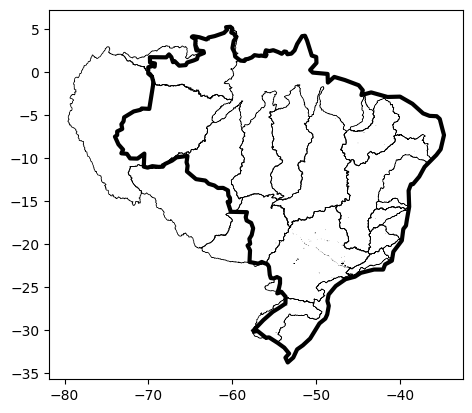

In [176]:
ax = br.plot(facecolor='none', linewidth=3)
basins.plot(ax=ax, facecolor='none', linewidth=0.5)

In [132]:
# br = gpd.read_file('/workspaces/bases/BR_UF_2022')
# br['geometry'] = br.simplify(0.005).to_crs(4326)

(-35.7207944099458, 7.232371429045038)

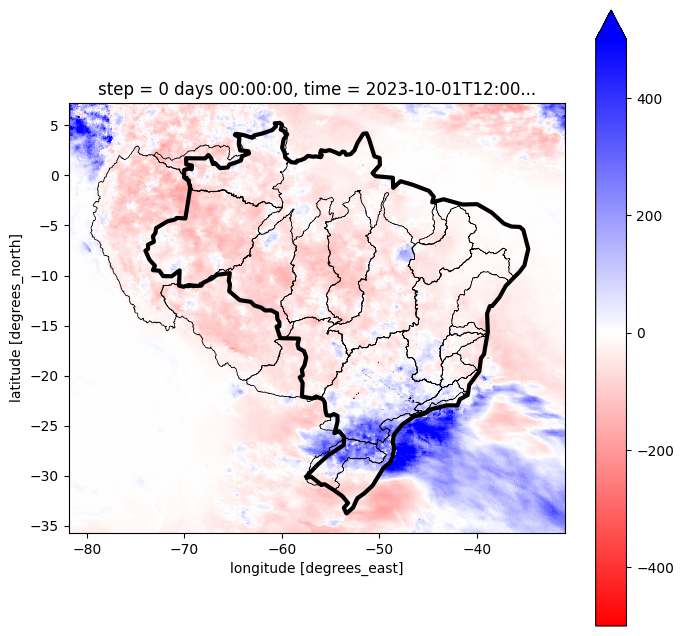

In [177]:
fig, ax = plt.subplots(figsize=(8, 8))


# Plot Brasil
br.plot(ax=ax, facecolor='none', linewidth=3)
basins.plot(ax=ax, facecolor='none', linewidth=0.5)

# Get the bounds of the plot
xmin, xmax, ymin, ymax = ax.axis()

anomaly.isel(time=1).plot(ax=ax, zorder=0, cmap='bwr_r', vmax=500, vmin=-500)
ax.set_xlim(xmin, -31)
ax.set_ylim(ymin, ymax)


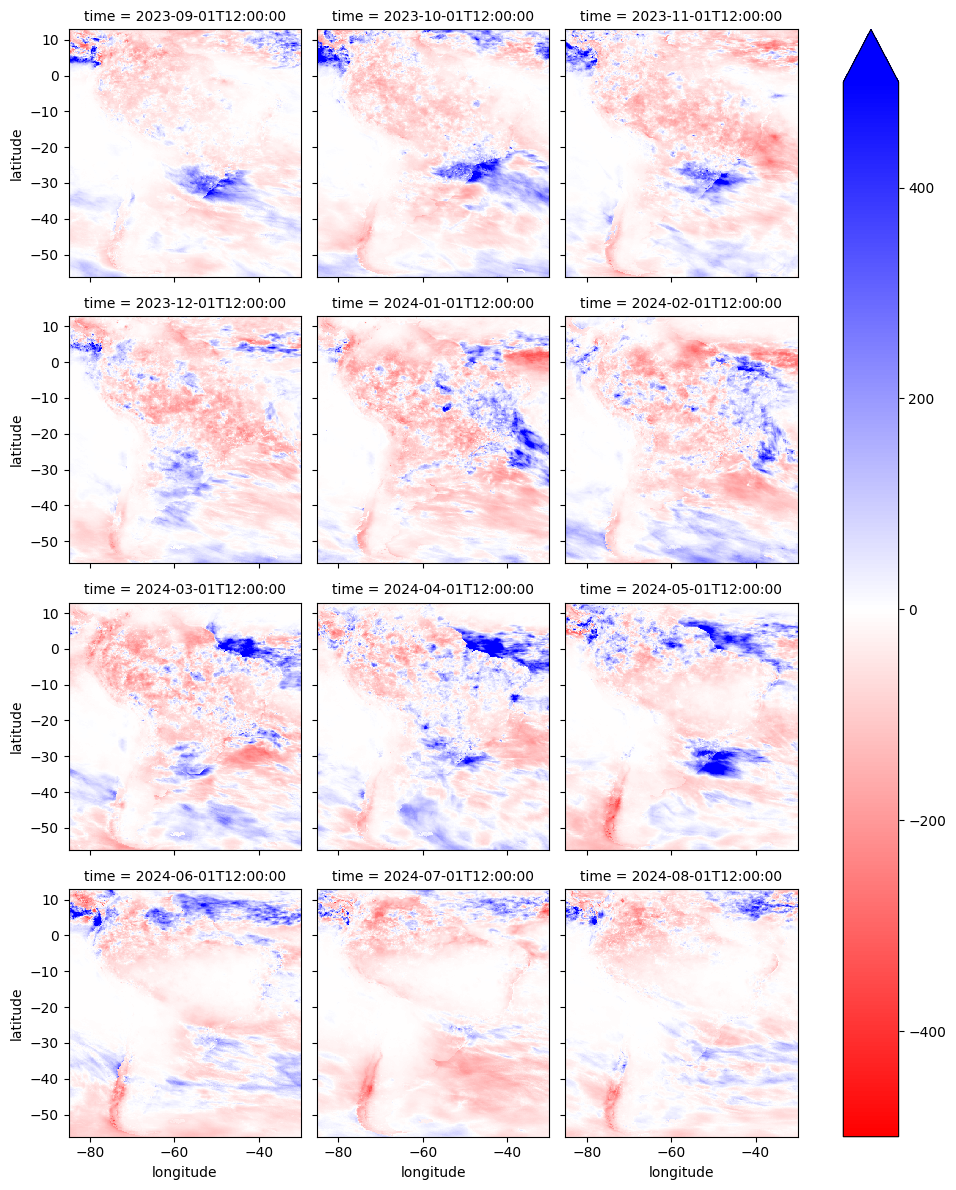

In [56]:
anomaly.plot.imshow(col='time', col_wrap=3, cmap='bwr_r', vmax=500, vmin=-500)

In [68]:
ax.get_images()

<a list of 0 AxesImage objects>

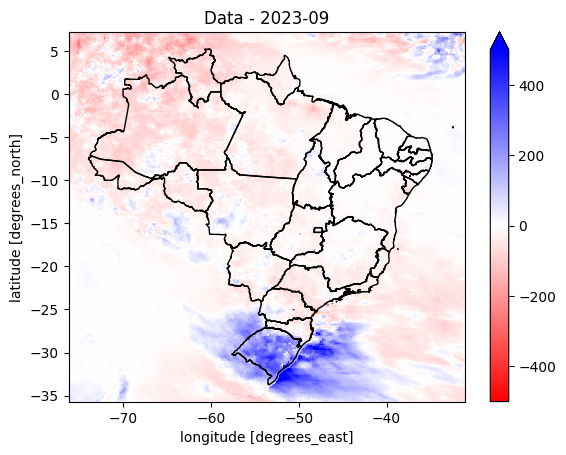

In [115]:
fig, ax = plt.subplots()

# img = ax.imshow(anomaly.isel(time=1).values, zorder=0)
br.plot(ax=ax, facecolor='none', zorder=1)

result = anomaly.isel(time=0).plot.imshow(ax=ax, cmap='bwr_r', vmax=500, vmin=-500)

def update(frame):
    ax.clear()
    # img = ax.imshow(anomaly.isel(time=1).values, zorder=0)
    br.plot(ax=ax, facecolor='none', zorder=1)
    # Get the bounds of the plot
    xmin, xmax, ymin, ymax = ax.axis()

    anomaly.isel(time=frame).plot.imshow(ax=ax, cmap='bwr_r', vmax=500, vmin=-500, add_colorbar=False)
    ax.set_xlim(xmin, -31)
    ax.set_ylim(ymin, ymax)

    date = DateProcessor.pretty_date(anomaly.time[frame].values.astype('str')[:10], "%Y-%m")
    ax.set_title(f"Data - {date}")

    return ax.get_images()

anim = FuncAnimation(fig, update, frames=len(anomaly.time), blit=True)


In [116]:
anim.save('monthly_anomaly.gif', writer='pillow', fps=1)

<Figure size 640x480 with 0 Axes>

## Accumulated Monthly Anomaly

Here, we can take advantage of the cubes we have already created before. What we will need to do is to calculate accumulated sum along the `time` axis. We can try to do this in xarray or we can do that directly with numpy. 

In [117]:
accum_cube = accum_cube.cumsum(dim='time')

In [118]:
avg_cube = avg_cube.cumsum(dim='time')

In [119]:
accum_anomaly = accum_cube - avg_cube

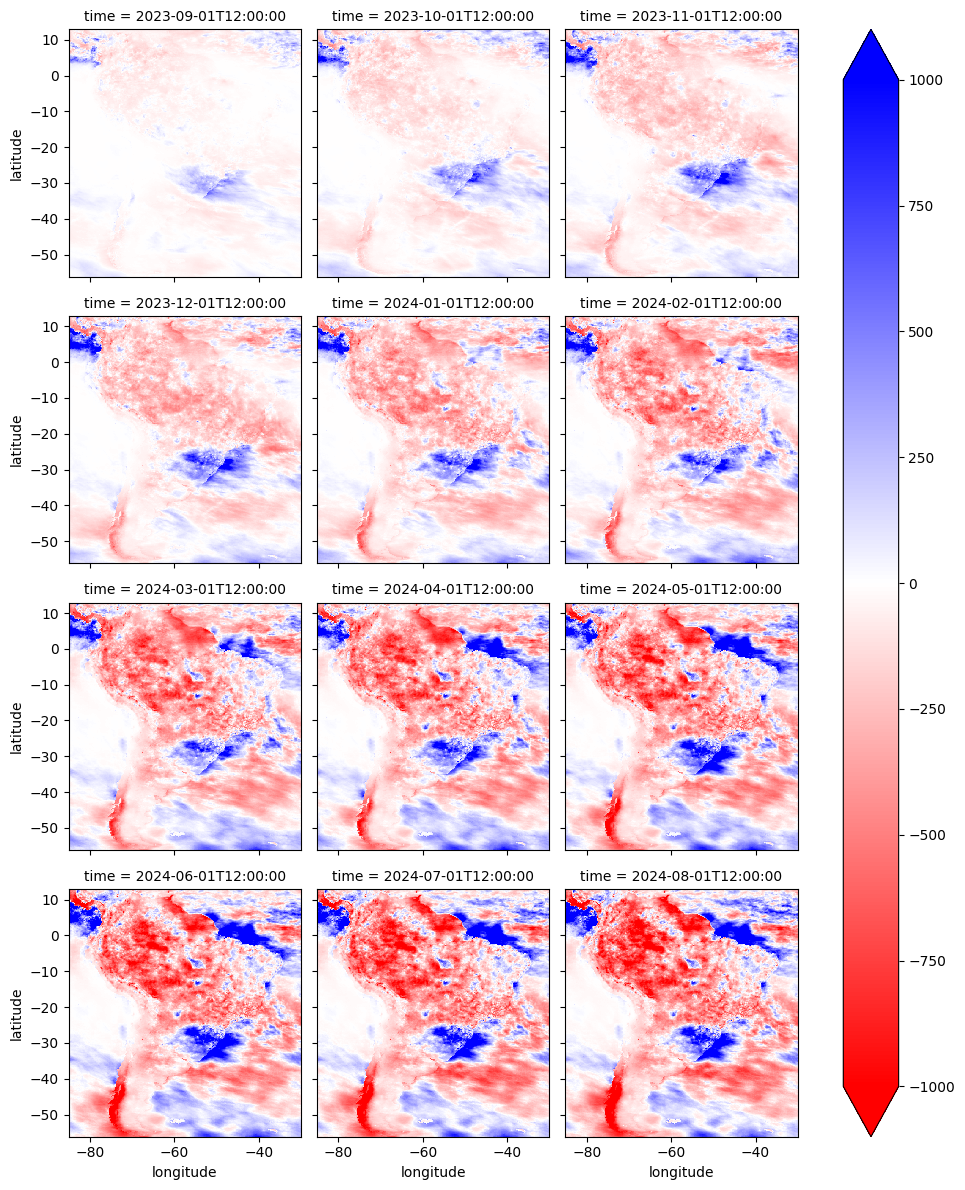

In [121]:
accum_anomaly.plot.imshow(col='time', col_wrap=3, cmap='bwr_r', vmax=1000, vmin=-1000)

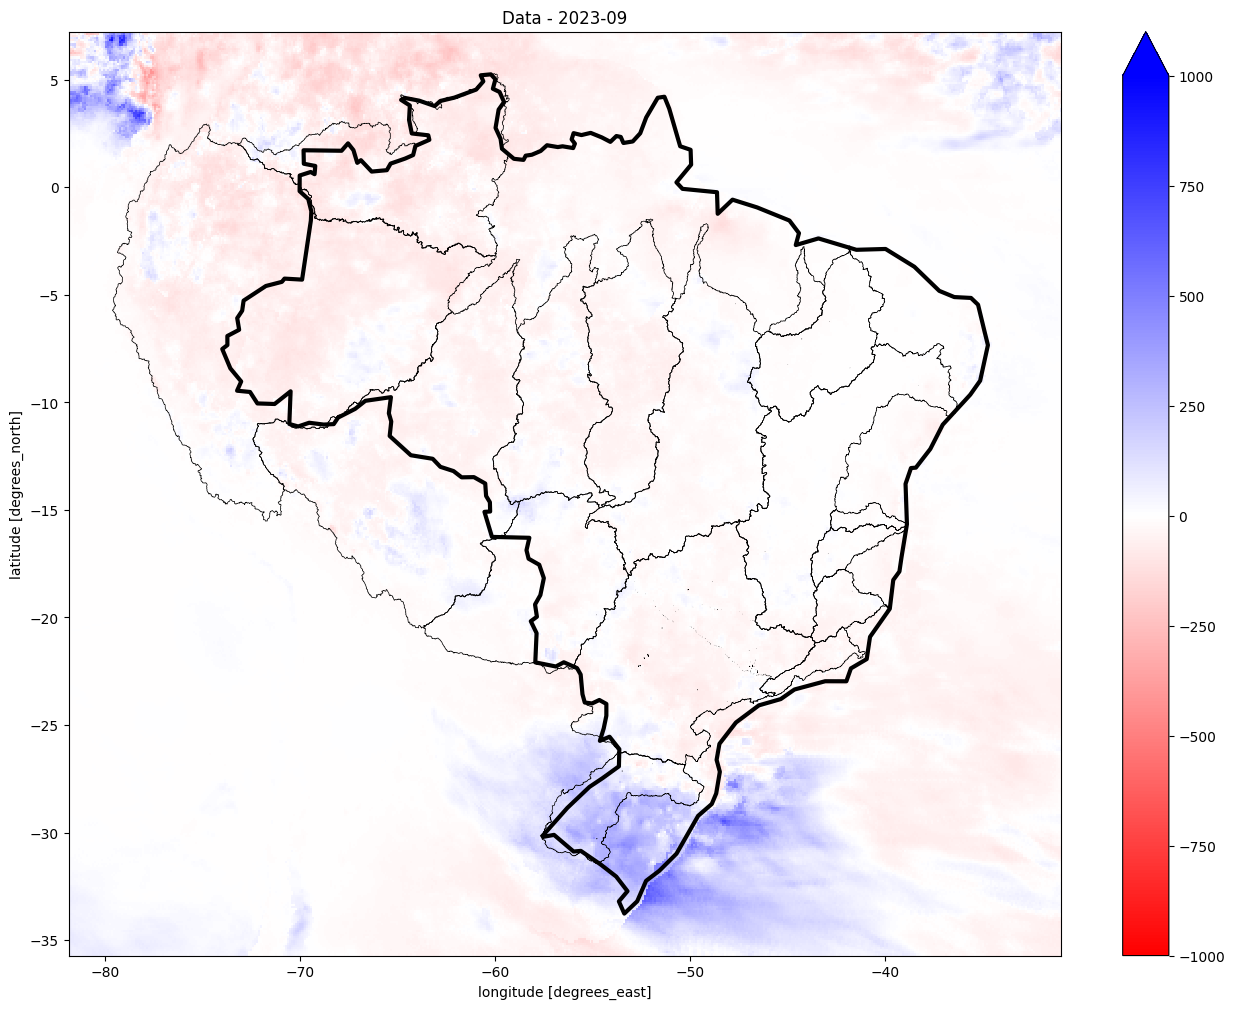

In [184]:
fig, ax = plt.subplots(figsize=(16, 12))

# img = ax.imshow(anomaly.isel(time=1).values, zorder=0)
br.plot(ax=ax, facecolor='none', zorder=1)

result = accum_anomaly.isel(time=0).plot.imshow(ax=ax, cmap='bwr_r', vmax=vmax, vmin=vmin)

def update(frame):
    ax.clear()
    # img = ax.imshow(anomaly.isel(time=1).values, zorder=0)
    br.plot(ax=ax, facecolor='none', linewidth=3)
    basins.plot(ax=ax, facecolor='none', linewidth=0.5)
    
    # Get the bounds of the plot
    xmin, xmax, ymin, ymax = ax.axis()

    accum_anomaly.isel(time=frame).plot.imshow(ax=ax, cmap='bwr_r', vmax=vmax, vmin=vmin, add_colorbar=False)
    ax.set_xlim(xmin, -31)
    ax.set_ylim(ymin, ymax)

    date = DateProcessor.pretty_date(accum_anomaly.time[frame].values.astype('str')[:10], "%Y-%m")
    ax.set_title(f"Data - {date}")

    return ax.get_images()

anim = FuncAnimation(fig, update, frames=len(accum_anomaly.time), blit=True)

In [185]:
anim.save('accum_monthly_anomaly.gif', writer='pillow', fps=1)

<Figure size 640x480 with 0 Axes>

In [ ]:
del accum_cube
del avg_cube
del accum_anomaly

## Accumulated Daily Anomaly

Now, let's try to make the anomaly considering the `DAILY` accumulation. 

In [196]:
from dateutil import relativedelta

In [202]:
today = DateProcessor.today()
start = today - relativedelta.relativedelta(months=12)
start = start + relativedelta.relativedelta(day=1)

start, today

(datetime.datetime(2023, 9, 1, 0, 0), datetime.datetime(2024, 9, 24, 0, 0))

In [203]:
rain_cube = downloader.create_cube(start, today, InpeTypes.DAILY_RAIN)

Ignoring index file '/workspaces/reports_folder/downloads2/DAILY/2024/09/MERGE_CPTEC_20240923.grib2.923a8.idx' older than GRIB file


In [204]:
avg_cube = downloader.create_cube(start, today, InpeTypes.DAILY_AVERAGE)

In [211]:
assert len(rain_cube.time) == len(avg_cube.time)
avg_cube['time'] = rain_cube.time

In [212]:
acc_rain_cube = rain_cube.cumsum(dim='time')
acc_avg_cube = avg_cube.cumsum(dim='time')

In [215]:
acc_rain_cube = acc_rain_cube.rio.reproject_match(acc_avg_cube)

# rename the dimensions in the accum xarray.dataarray to longitude and latitude
acc_rain_cube = acc_rain_cube.rename({"x": "longitude", "y": "latitude"})


In [216]:
anomaly = acc_rain_cube - acc_avg_cube

Text(0.5, 0.98, 'Anomalia de chuva acumulada entre:')

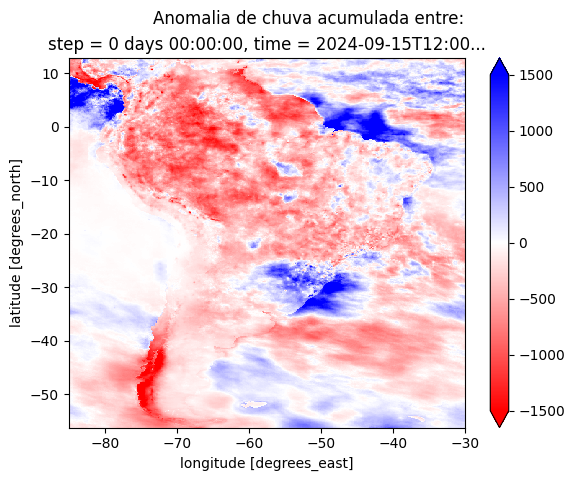

In [240]:
fig, ax = plt.subplots()
anomaly.isel(time=380).plot.imshow(ax=ax, cmap='bwr_r', vmin=vmin, vmax=vmax)
fig.suptitle('Anomalia de chuva acumulada entre:')


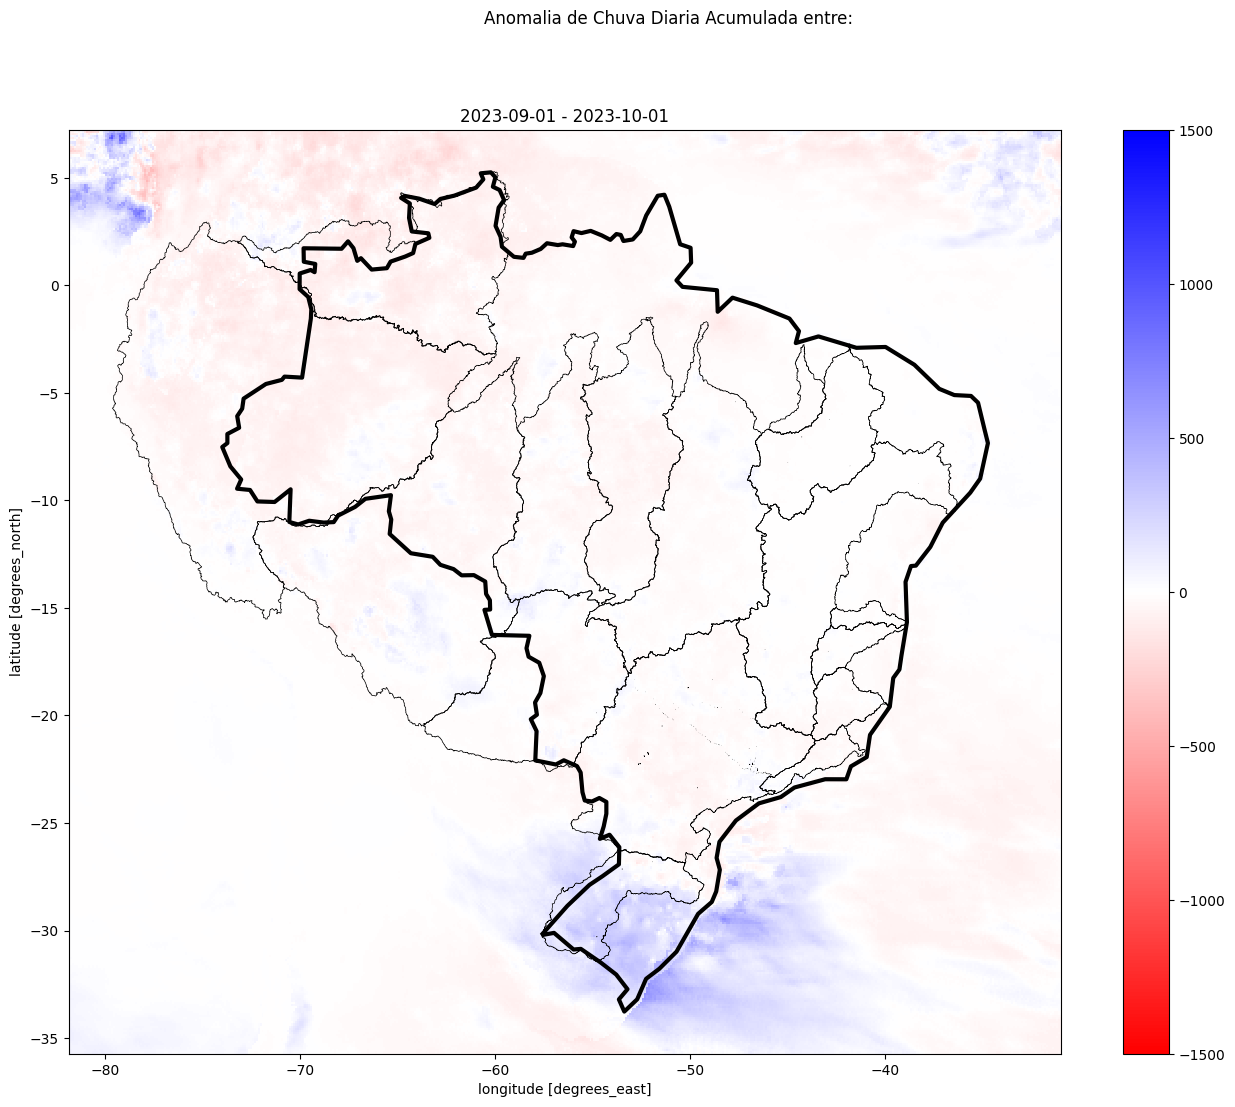

In [237]:
fig, ax = plt.subplots(figsize=(16, 12))
start_day = 30

# img = ax.imshow(anomaly.isel(time=1).values, zorder=0)
br.plot(ax=ax, facecolor='none', zorder=1)

result = anomaly.isel(time=start_day).plot.imshow(ax=ax, cmap='bwr_r', vmax=vmax, vmin=vmin)

def update(frame):
    day = start_day + frame
    ax.clear()
    # img = ax.imshow(anomaly.isel(time=1).values, zorder=0)
    br.plot(ax=ax, facecolor='none', linewidth=3)
    basins.plot(ax=ax, facecolor='none', linewidth=0.5)
    
    # Get the bounds of the plot
    xmin, xmax, ymin, ymax = ax.axis()

    anomaly.isel(time=day).plot.imshow(ax=ax, cmap='bwr_r', vmax=vmax, vmin=vmin, add_colorbar=False)
    ax.set_xlim(xmin, -31)
    ax.set_ylim(ymin, ymax)

    date = DateProcessor.pretty_date(anomaly.time[day].values.astype('str')[:10], "%Y-%m-%d")
    fig.suptitle("Anomalia de Chuva Diaria Acumulada entre:")
    ax.set_title(f"{DateProcessor.pretty_date(start, '%Y-%m-%d')} - {date}")

    return ax.get_images()

anim = FuncAnimation(fig, update, frames=len(anomaly.time) - start_day, blit=True)

In [238]:
anim.save('accum_daily_anomaly.gif', writer='pillow', fps=4)

<Figure size 640x480 with 0 Axes>

In [208]:
rain_cube.time

<xarray.DataArray 'time' (time: 390)>
array(['2023-09-01T12:00:00.000000000', '2023-09-02T12:00:00.000000000',
       '2023-09-03T12:00:00.000000000', ..., '2024-09-22T12:00:00.000000000',
       '2024-09-23T12:00:00.000000000', '2024-09-24T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 2023-09-01T12:00:00 ... 2024-09-24T12:...
    step         timedelta64[ns] ...
    surface      float64 ...
    valid_time   datetime64[ns] ...
    spatial_ref  int64 0
Attributes:
    long_name:      initial time of forecast
    standard_name:  forecast_reference_time

In [209]:
avg_cube.time

<xarray.DataArray 'time' (time: 390)>
array(['2020-09-01T12:00:00.000000000', '2020-09-02T12:00:00.000000000',
       '2020-09-03T12:00:00.000000000', ..., '2020-09-22T12:00:00.000000000',
       '2020-09-23T12:00:00.000000000', '2020-09-24T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 2020-09-01T12:00:00 ... 2020-09-24T12:...
    spatial_ref  int64 0
Attributes:
    long_name:  Time

In [193]:
dates = DateProcessor.dates_range('2023-08-01', today, DateFrequency.DAILY)

In [194]:
len(dates)

31

In [186]:
rain = downloader.open_file('2023-08-01', datatype=InpeTypes.DAILY_RAIN)
avg = downloader.open_file('2023-08-01', datatype=InpeTypes.DAILY_AVERAGE)

In [191]:
rain.mean()

<xarray.DataArray 'prec' ()>
array(2.475543, dtype=float32)
Coordinates:
    time         datetime64[ns] ...
    step         timedelta64[ns] ...
    surface      float64 ...
    valid_time   datetime64[ns] ...
    spatial_ref  int64 0

In [192]:
avg.mean()

<xarray.DataArray 'pmed' ()>
array(2.92414559)
Coordinates:
    spatial_ref  int64 0